# Raw VS smoothed in situ drifters focalised one on drifter type
- global distribution figure
- global rms figure

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.xarray  # noqa
import holoviews as hv
#
import pynsitu as pyn
from pynsitu.maps import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

from lib import raw_dir, root_dir, smoothed_dir, KEYS, list_type, open_L1_dataset, open_L2_dataset, images_dir

import datetime
from scipy.stats import norm

/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


________
# MS

In [2]:
def std_dataset_L2():
    var_ms = ['x','y','u','v','ax','ay']
    def std(ds):
        ds_=ds[var_ms]
        return ds_.std('time').mean('id')
    list_method = ['variational','lowess']
    l_method = []
    for method in list_method:
        list_sampling = ['10min', '30min', '1h']
        l_sampling=[]
        if method == 'lowess': version='v0'
        elif method=='variational': version='v1'
        for sampling in list_sampling:
            l_drifter_type =[]
            for drifter_type in list_type:
                try : ds = open_L2_dataset(smoothed_dir, drifter_type, method, sampling, version=version)
                except : continue
                ds=ds.where(ds.gap_mask==0)
                l_drifter_type.append(std(ds))
            l_sampling.append(xr.concat(l_drifter_type, dim = pd.Index(list_type, name='drifter_type')))
        l_method.append(xr.concat(l_sampling, dim = pd.Index(list_sampling, name='sampling')))
    return xr.concat(l_method, dim = pd.Index(list_method, name='smoothing_method'))

def std_dataset_L1():
    var_ms = ['x','y','u','v','ax','ay']
    def std(ds):
        ds_=ds[var_ms]
        return ds_.std('time').mean('id')
    l_drifter_type =[]
    for drifter_type in list_type:
        try : ds = open_L1_dataset(raw_dir, drifter_type)
        except : continue
        l_drifter_type.append(std(ds))
    return xr.concat(l_drifter_type, dim = pd.Index(list_type, name='drifter_type'))

dsms2 = std_dataset_L2()     
dsms1 = std_dataset_L1()

/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_melodi_eodyn_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_spotter_lops_30min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_bcg_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIF

In [3]:
ratio = ((dsms1.ax**2)-(dsms2.ax**2))/(dsms1.ax**2)*100

In [4]:
ratio.mean(['drifter_type', 'sampling'])

<xarray.DataArray 'ax' (smoothing_method: 2)>
array([75.04041919, 87.50609859])
Coordinates:
  * smoothing_method  (smoothing_method) object 'variational' 'lowess'

In [5]:
dsms2

<xarray.Dataset>
Dimensions:           (smoothing_method: 2, sampling: 3, drifter_type: 12)
Coordinates:
  * drifter_type      (drifter_type) object 'carthe_cnr_5min' ... 'svp_shom_1...
  * sampling          (sampling) object '10min' '30min' '1h'
  * smoothing_method  (smoothing_method) object 'variational' 'lowess'
Data variables:
    x                 (smoothing_method, sampling, drifter_type) float64 8.32...
    y                 (smoothing_method, sampling, drifter_type) float64 9.73...
    u                 (smoothing_method, sampling, drifter_type) float64 0.20...
    v                 (smoothing_method, sampling, drifter_type) float64 0.19...
    ax                (smoothing_method, sampling, drifter_type) float64 1.21...
    ay                (smoothing_method, sampling, drifter_type) float64 1.22...

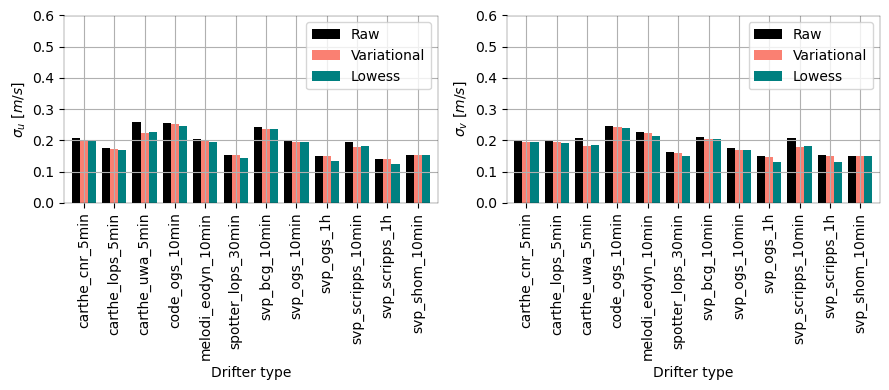

In [6]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs= axs.flatten()

ax=axs[0]
var='u'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling='30min', smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling='30min', smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_u}$ $[m/s]$')

ax=axs[1]
var='v'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling='30min', smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling='30min', smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_v}$ $[m/s]$')

for ax in axs :
    ax.grid()
    ax.set_xlabel('Drifter type')
    ax.set_ylim(0, 0.6)
fig.tight_layout()

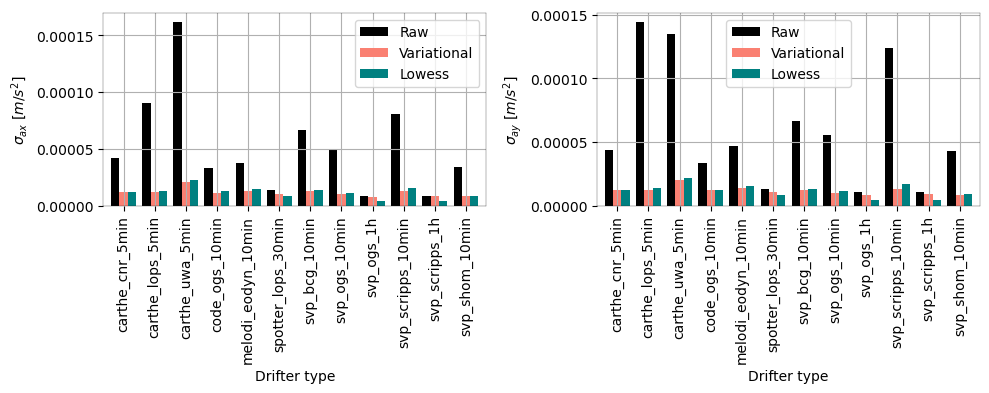

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs= axs.flatten()
sa ='30min'
ax=axs[0]
var='ax'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling=sa, smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling=sa, smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_{ax}}$ $[m/s^2]$')

ax=axs[1]
var='ay'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling=sa, smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling=sa, smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_{ay}}$ $[m/s^2]$')

for ax in axs :
    ax.grid()
    ax.set_xlabel('Drifter type')
    #ax.set_ylim(0, 0.6)
fig.tight_layout()

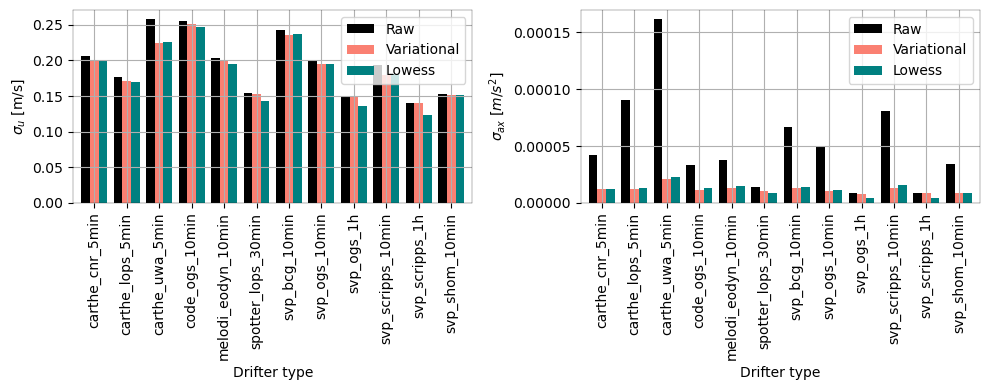

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs= axs.flatten()

ax=axs[0]
var='u'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling=sa, smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling=sa, smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_u$ [m/s]')

ax=axs[1]
var='ax'
df1 = dsms1[var].to_series()
df2s = dsms2[var].sel(sampling=sa, smoothing_method='lowess').to_series()
df2v = dsms2[var].sel(sampling=sa, smoothing_method='variational').to_series()
df = pd.DataFrame({'Raw': df1, 'Variational':df2v, 'Lowess':df2s })
df.plot.bar( color=['k', 'salmon', 'teal'], ax=ax, width=0.8)
ax.set_ylabel(r'$\sigma_{ax}$ $[m/s^2]$')

for ax in axs :
    ax.grid()
    ax.set_xlabel('Drifter type')
    #ax.set_ylim(0, 0.6)
fig.tight_layout()
path = os.path.join(images_dir, 'istt_barrms_uax.jpeg')
fig.savefig(path, dpi=250)

## same for the different smoothed sampling
-0.25\% max pour difference relative en position
-8.24\% max pour les vitesses
-5\% max pour les accelerations

1h-rms > 30min rms > 10min rms

In [9]:
((dsms2.isel(sampling=1)-dsms2.isel(sampling=0))/dsms2.isel(sampling=0)).mean()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    sampling  <U5 '10min'
Data variables:
    x         float64 7.009e-06
    y         float64 -0.0006894
    u         float64 -0.001251
    v         float64 -0.001573
    ax        float64 -0.02213
    ay        float64 -0.01845

In [10]:
((dsms2.isel(sampling=1)-dsms2.isel(sampling=0))/dsms2.isel(sampling=0)).median()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    sampling  <U5 '10min'
Data variables:
    x         float64 1.745e-06
    y         float64 -3.539e-05
    u         float64 -0.0006471
    v         float64 -0.0002586
    ax        float64 -0.01341
    ay        float64 -0.01109

In [11]:
((dsms2.isel(sampling=2)-dsms2.isel(sampling=0))/dsms2.isel(sampling=0)).mean()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    sampling  <U5 '10min'
Data variables:
    x         float64 -0.0009
    y         float64 -0.001989
    u         float64 -0.007168
    v         float64 -0.008383
    ax        float64 -0.05366
    ay        float64 -0.05317

In [12]:
((dsms2.isel(sampling=2)-dsms2.isel(sampling=0))/dsms2.isel(sampling=0)).median()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    sampling  <U5 '10min'
Data variables:
    x         float64 -0.0003234
    y         float64 -0.0004449
    u         float64 -0.004387
    v         float64 -0.004626
    ax        float64 -0.03429
    ay        float64 -0.04277

In [13]:
ds1.x.differentiate?

Object `ds1.x.differentiate` not found.


________
# Distribution
## For all drifters types,raw, lowess, variational sampling =30min

In [4]:
def plot_histogram(darray, ax, bins=np.linspace(-1, 1, 60), **kwargs):
    h, b = np.histogram(darray, bins=bins, density=True)
    ax.plot(bins[:-1] + np.diff(bins) / 2, h, **kwargs)

/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_cnr_20230715_020629_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_lops_20230912_192142_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_uwa_20231006_094155_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_code_ogs_20230628_101654_10min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_lowess_30mi

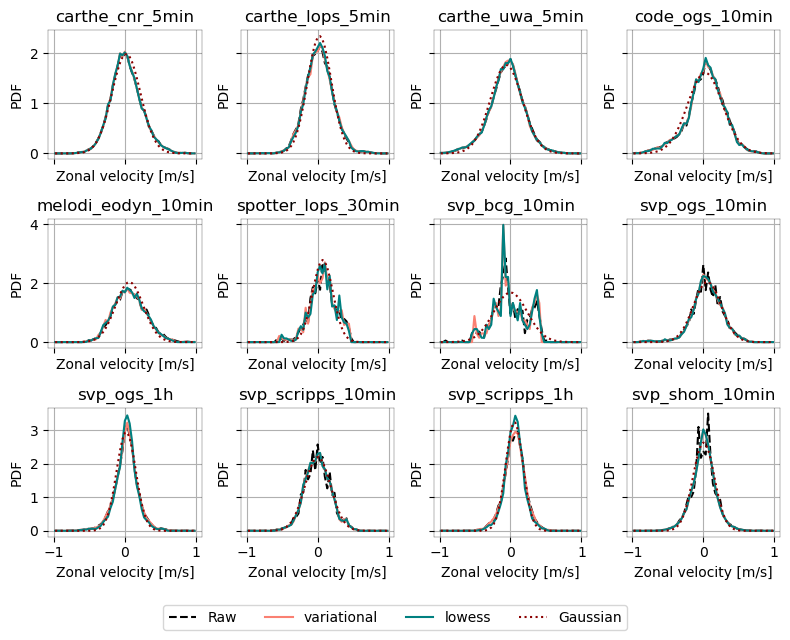

In [9]:
def plot_distribution(var, varlabel, bins=np.linspace(-1, 1, 60), ylim=None, figsize = (8, 6)):
    fig, axs = plt.subplots(3,4,sharex=True,sharey='row', figsize=figsize)
    axs = axs.flatten()
    list_method = ['variational','lowess']
    i=0
    lw=1.5
    save_bins = bins
    
    for drifter_type in list_type:
        ax=axs[i]
        ax.grid()
        cm ={'lowess':'teal', 'variational':'salmon'}
            
        #RAW
        ds1 = open_L1_dataset(raw_dir, drifter_type)[var]
        if i==0: plot_histogram(ds1, ax=ax, bins=bins, color = 'k', ls='--', label='Raw', lw=lw)
        else : plot_histogram(ds1, ax=ax, bins=bins, color = 'k', ls='--', lw=lw)
        
        # SMOOTHED
        for method in list_method:
            if method == 'lowess': version='v0'
            elif method=='variational': version='v1'
            sampling='30min'
            try : 
                ds2 = open_L2_dataset(smoothed_dir, drifter_type, method, sampling, version=version)
            except : continue
            ds2 = ds2.where(ds2.gap_mask==0)[var]# exclude gaps
            if i ==0: plot_histogram(ds2, ax=ax, color = cm[method],bins=bins, label = method, lw=lw)
            else : plot_histogram(ds2, ax=ax,bins=bins, color = cm[method], lw=lw)
        
        #GAUSSIAN for comparison
        binspdf = bins[:-1] + np.diff(bins) / 2
        mean = ds2.mean()
        std = ds2.std('time').mean('id')
        pdf = norm.pdf(binspdf, mean, std)
        if i==0 : ax.plot(binspdf, pdf, c="darkred", ls=':', label="Gaussian", lw=lw)
        else : ax.plot(binspdf, pdf, c="darkred", ls=':', lw=lw)
            
        ax.set_xlabel(varlabel)
        ax.set_ylabel('PDF')
        ax.set_title(drifter_type)
        if ylim : ax.set_ylim(ylim)
        i+=1
        bins = save_bins
        
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.005), ncol=4)
    fig.tight_layout()
    return fig
        
fig = plot_distribution('u', 'Zonal velocity [m/s]')
path = os.path.join(images_dir, 'istt_distrib_u.png')
fig.savefig(path, dpi=250,bbox_inches = 'tight')

/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_cnr_20230715_020629_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_lops_20230912_192142_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_uwa_20231006_094155_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_code_ogs_20230628_101654_10min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_lowess_30mi

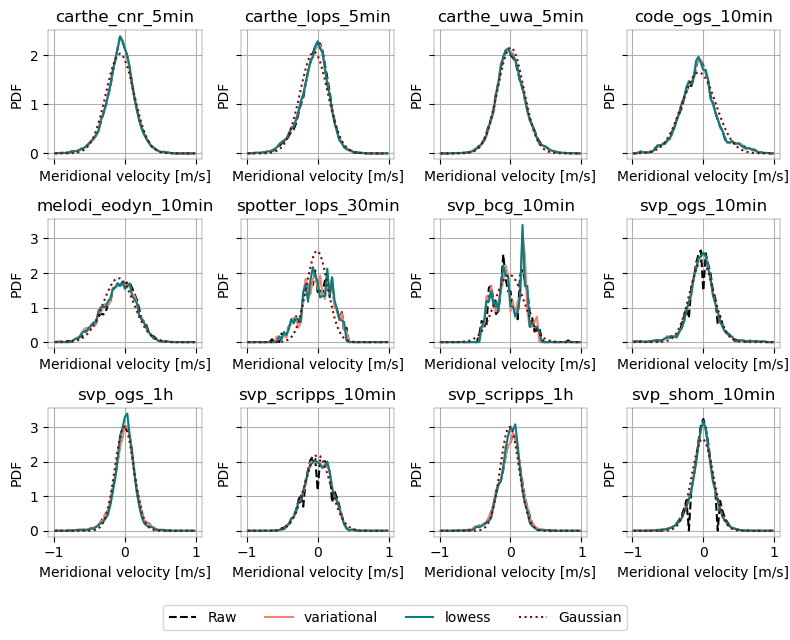

In [10]:
fig = plot_distribution('v', 'Meridional velocity [m/s]') 
path = os.path.join(images_dir, 'istt_distrib_v.png')
fig.savefig(path, dpi=250,bbox_inches = 'tight')

/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_cnr_20230715_020629_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_lops_20230912_192142_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_uwa_20231006_094155_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_code_ogs_20230628_101654_10min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_lowess_30mi

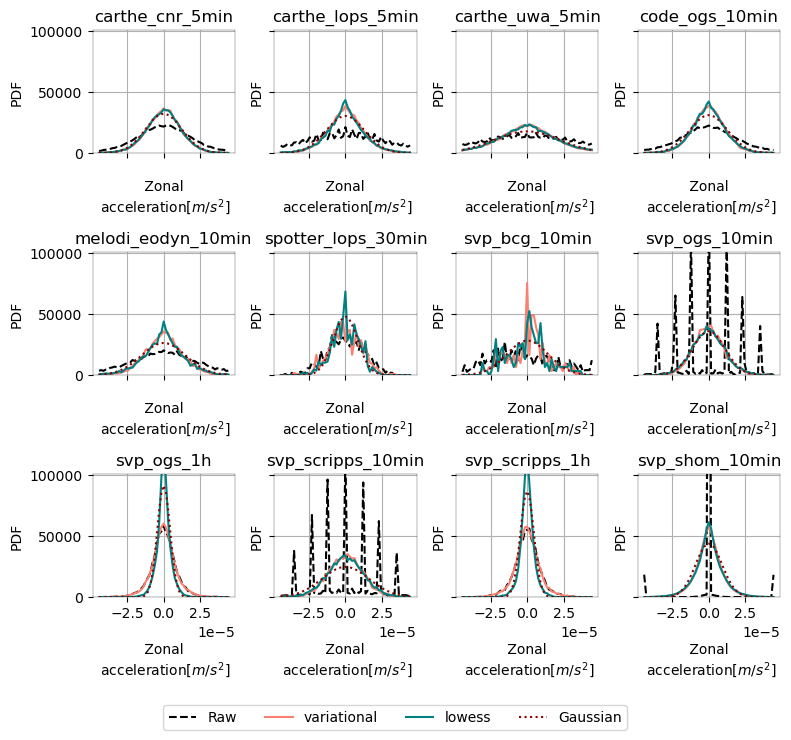

In [11]:
fig = plot_distribution('ax', '\n Zonal \n acceleration' +r'$[m/s^2]$', bins=np.linspace(-4.5e-5,4.5e-5, 60), ylim=(0,101000), figsize=(8,7)) 
path = os.path.join(images_dir, 'istt_distrib_ax.png')
fig.savefig(path, dpi=250, bbox_inches = 'tight')

/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_cnr_20230715_020629_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_lops_20230912_192142_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_carthe_uwa_20231006_094155_5min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_lowess_30min_v0.nc
/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_code_ogs_20230628_101654_10min.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_30min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_lowess_30mi

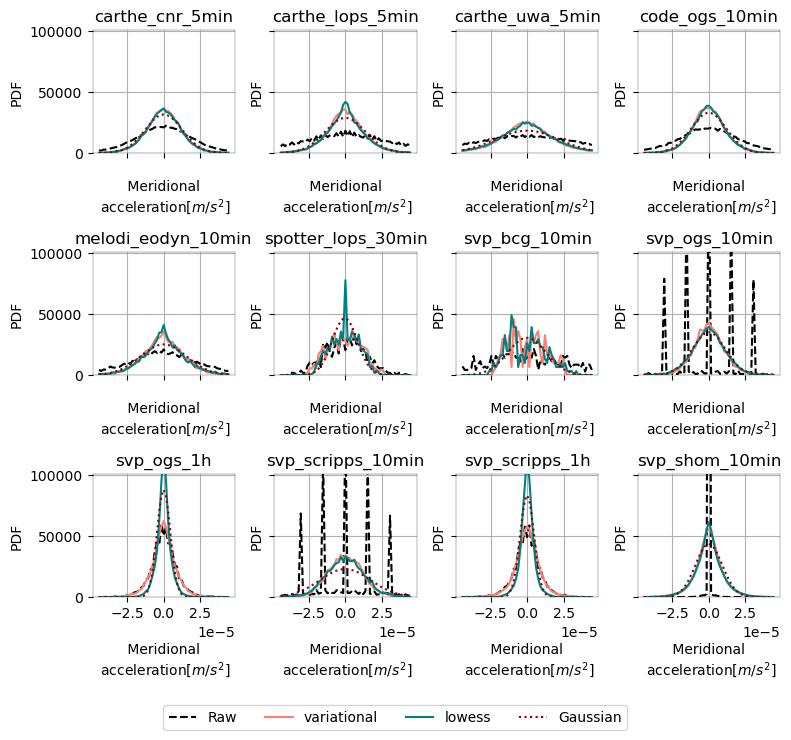

In [12]:
fig = plot_distribution('ay', '\n Meridional \n acceleration' +r'$[m/s^2]$', bins=np.linspace(-4.5e-5,4.5e-5, 60), ylim=(0,101000), figsize=(8,7))
path = os.path.join(images_dir, 'istt_distrib_ay.png')
fig.savefig(path, dpi=250, bbox_inches = 'tight')

### Acceleration taking discrete accelaration

In [51]:
ds1 = open_L1_dataset(raw_dir, 'svp_ogs_10min')

/Users/mdemol/DATA_DRIFTERS/drifters/raw/L1_svp_ogs_20231005_140000_10min.nc


In [58]:
ds1.x.differentiate(coord='time',datetime_unit='1s').isel(id=0).hvplot(kind='scatter') * ds1.u.isel(id=0).hvplot(kind='scatter')

:Overlay
   .Scatter.I  :Scatter   [time]   (x)
   .Scatter.II :Scatter   [time]   (u)

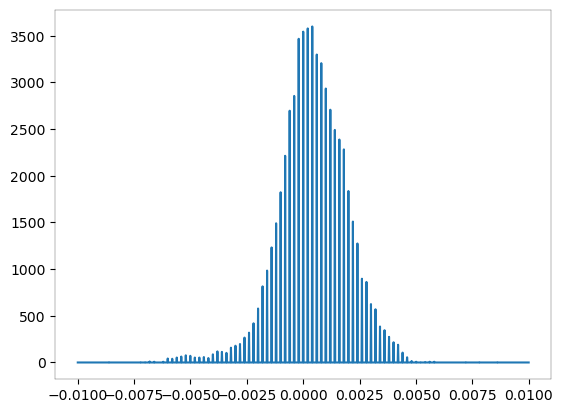

In [59]:
fig, ax = plt.subplots(1,1)
plot_histogram(ds1.lon.diff(dim='time'), bins=np.linspace(-0.01, 0.01, 1200), ax=ax)

________
# Spectra
## For all drifters types,raw, lowess, variational sampling =30min

In [9]:
list_type_spectrum_ok = ['carthe_cnr_5min',
 'carthe_lops_5min',
 'carthe_uwa_5min',
 'code_ogs_10min',
 'melodi_eodyn_10min',
 'svp_ogs_10min',
 'svp_ogs_1h',
 'svp_scripps_10min',
 'svp_scripps_1h',
 'svp_shom_10min']

In [16]:
def spectrum__(ds, nperseg="10D", detrend=False, complex=('u','v')):
    spec_id = []
    for i in range(ds.dims['id']):
        try : spec_id.append(ds.isel(id=i).dropna('time').ts.spectrum(unit="1D", nperseg=nperseg, detrend=detrend, complex=complex))
        except : 
            if ds.isel(id=i).dropna('time').time.max()-ds.isel(id=i).dropna('time').time.min()<=pd.Timedelta(nperseg): 
                print(f'{i} too short')
                continue
            else : assert False, i
    return xr.concat(spec_id,dim='id')

def spectrum_var(ds, nperseg="10D", detrend=False,):
    S = []
    for var in [('x', 'y'),('u', 'v'), ('ax', 'ay')]:
        S.append(spectrum__(ds, nperseg="10D", detrend=False, complex=var))
    return xr.merge(S)

def spectrum_all(list_type=list_type, nperseg="10D", detrend=False):
    list_method = ['variational','lowess']
    l_method = []
    for method in list_method:
        if method == 'lowess': version='v0'
        elif method=='variational': version='v1'
        list_sampling = ['10min', '30min', '1h']
        l_sampling=[]
        for sampling in list_sampling:
            l_drifter_type =[]
            for drifter_type in list_type:
                try : ds = open_L2_dataset(smoothed_dir, drifter_type, method, sampling, mask=False, version=version)
                except : continue
                l_drifter_type.append(spectrum_var(ds))
            l_sampling.append(xr.concat(l_drifter_type, dim = pd.Index(list_type, name='drifter_type')))
        l_method.append(xr.concat(l_sampling, dim = pd.Index(list_sampling, name='sampling')))
    return xr.concat(l_method, dim = pd.Index(list_method, name='smoothing_method'))
    
dss = spectrum_all(list_type_spectrum_ok, nperseg='10D', detrend='linear')

/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_melodi_eodyn_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_shom_10min_variational_10min_v1.nc
4 too short
4 too short
4 too short
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_3

In [13]:
linthresh = 5e-1
linscale = 0.3

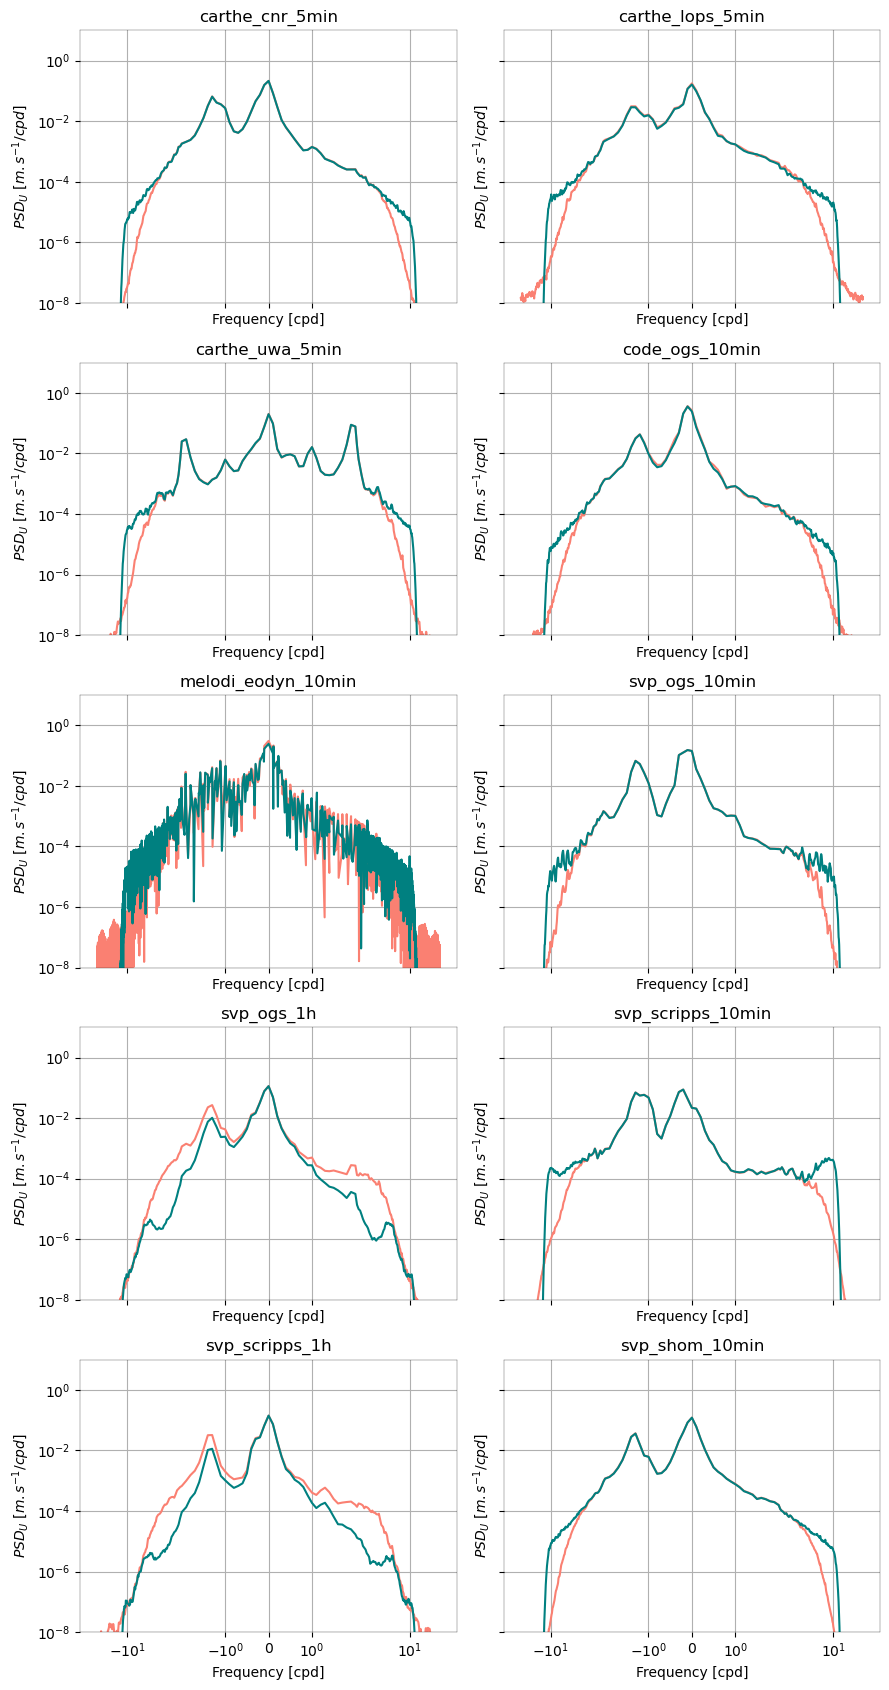

In [17]:
fig, axs = plt.subplots(5,2,sharey=True, sharex=True, figsize=(9,17))
axs=axs.flatten()
i=0
ax=axs[0]
for drifter_type in list_type_spectrum_ok :
    ds_ = dss.isel(sampling=1).sel(drifter_type=drifter_type).mean('id').dropna('frequency')
    ds_.isel(smoothing_method=0).u_v.plot(color='salmon', ax=ax)
    ds_.isel(smoothing_method=1).u_v.plot(color='teal', ax=ax)
    ax.set_xscale("symlog")#, linthresh=linthresh, linscale=linscale)
    ax.set_yscale("log")
    ax.set_title(drifter_type)
    ax.grid()
    ax.set_ylabel(r'$PSD_U$ $[m.s^{-1}/cpd]$')
    ax.set_xlabel('Frequency [cpd]')
    ax.set_ylim(1e-8, 10)
    i+=1
    try : ax=axs[i]
    except: break
                                          
fig.tight_layout()
path = os.path.join(images_dir, 'istt_psd_U.png')
fig.savefig(path, dpi=250)

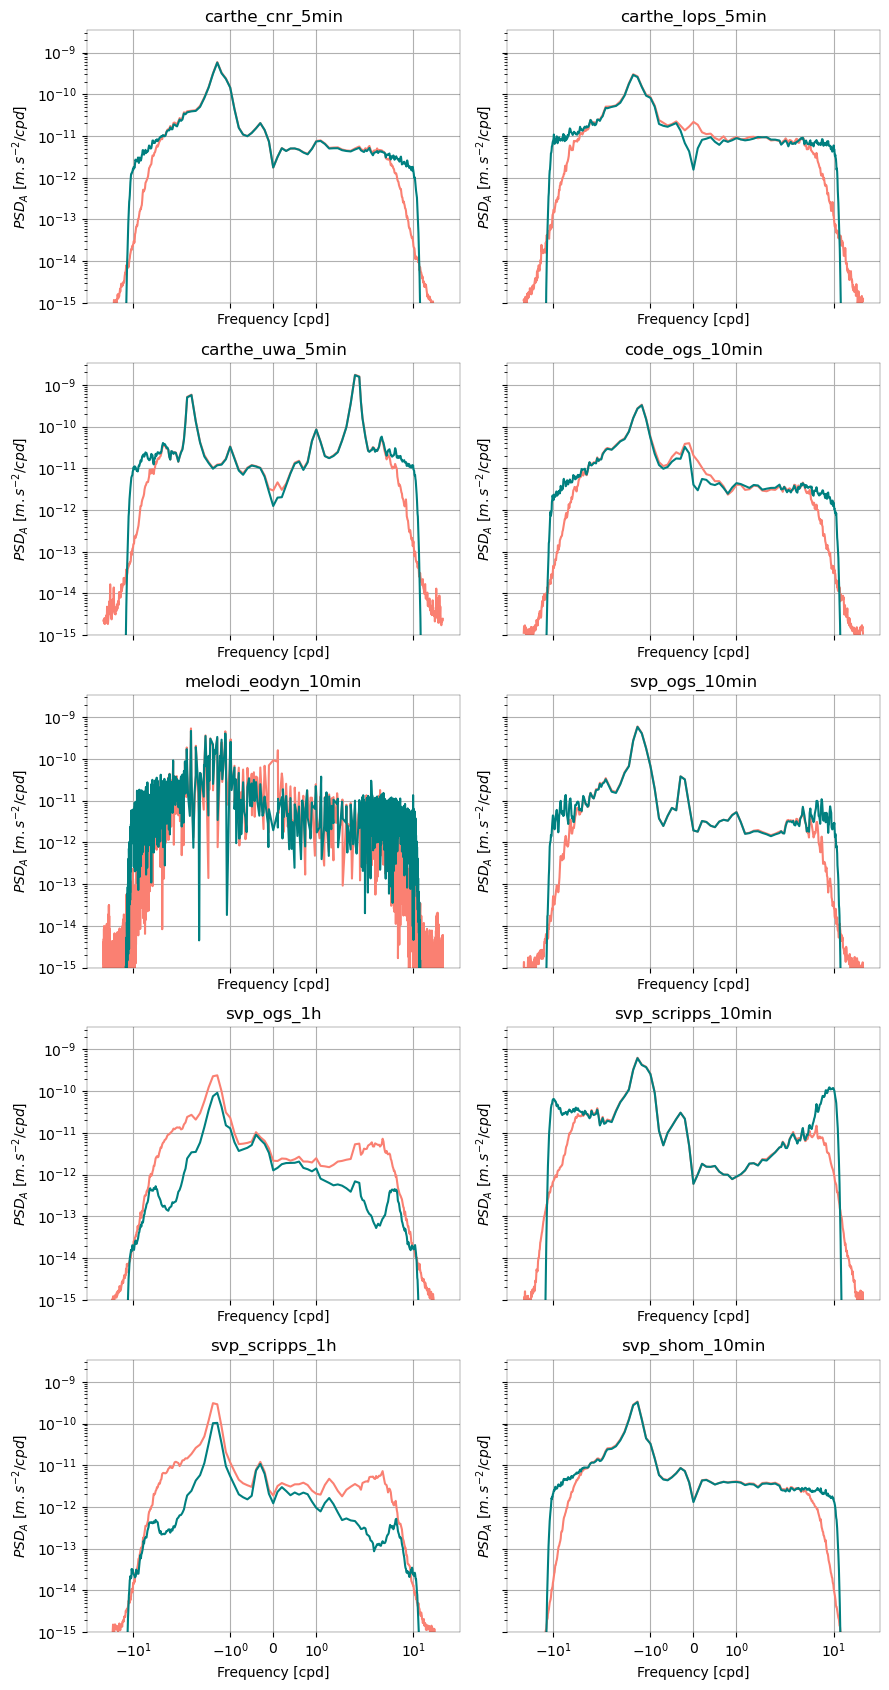

In [19]:
fig, axs = plt.subplots(5,2,sharey=True, sharex=True, figsize=(9,17))
axs=axs.flatten()
i=0
ax=axs[0]
for drifter_type in list_type_spectrum_ok :
    ds_ = dss.isel(sampling=1).sel(drifter_type=drifter_type).mean('id').dropna('frequency')
    ds_.isel(smoothing_method=0).ax_ay.plot(color='salmon', ax=ax)
    ds_.isel(smoothing_method=1).ax_ay.plot(color='teal', ax=ax)
    ax.set_xscale("symlog")#, linthresh=linthresh, linscale=linscale)
    ax.set_yscale("log")
    ax.set_title(drifter_type)
    ax.grid()
    ax.set_ylabel(r'$PSD_A$ $[m.s^{-2}/cpd]$')
    ax.set_xlabel('Frequency [cpd]')
    ax.set_ylim(1e-15)
    i+=1
    try : ax=axs[i]
    except: break
fig.tight_layout()
path = os.path.join(images_dir, 'istt_psd_A.png')
fig.savefig(path, dpi=250)

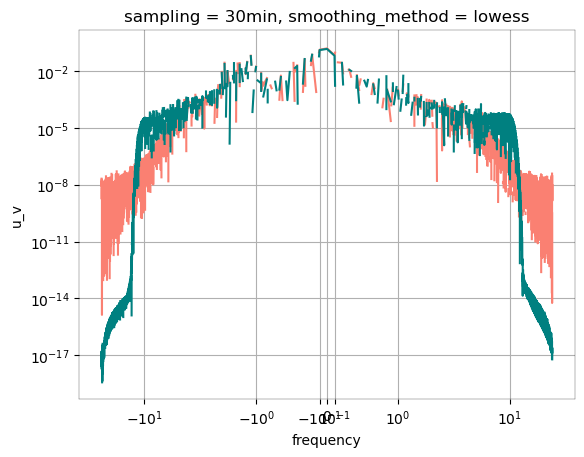

In [76]:
ds_med = dss.isel(sampling=1).where(dss.drifter_type!='carthe_uwa_5min', drop=True).mean('id').mean('drifter_type')
ds_med.isel(smoothing_method=0).u_v.plot(color='salmon')
ds_med.isel(smoothing_method=1).u_v.plot(color='teal')
plt.xscale("symlog", linthresh=linthresh, linscale=linscale)
plt.yscale("log")
plt.grid()

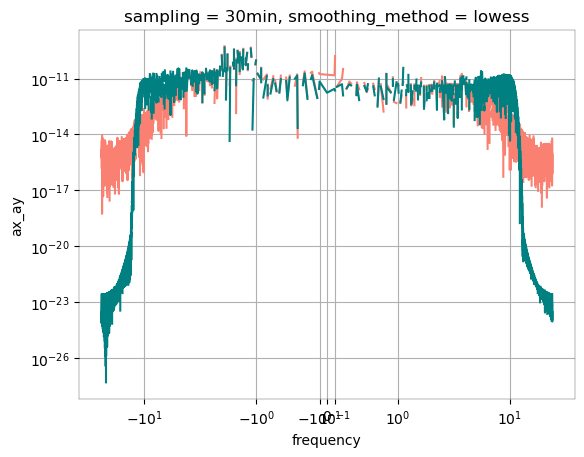

In [67]:
ds_med.isel(smoothing_method=0).ax_ay.plot(color='salmon')
ds_med.isel(smoothing_method=1).ax_ay.plot(color='teal')
plt.xscale("symlog", linthresh=linthresh, linscale=linscale)
plt.yscale("log")
plt.grid()

__________
# Count GAP

In [83]:
def count_for_all_id(ds):
    sseg=0
    stot=0
    for i in range(ds.dims['id']):
        sseg += ds.isel(id=i).where(ds.isel(id=i).gap_mask==0).u.count()
        stot += ds.isel(id=i).u.count()
    return sseg/stot

def count_gap():
    list_method = ['variational','lowess']
    l_method = []
    for method in list_method:
        list_sampling = ['10min', '30min', '1h']
        l_sampling=[]
        if method == 'lowess': version='v0'
        elif method=='variational': version='v1'
        for sampling in list_sampling:
            l_drifter_type =[]
            for drifter_type in list_type:
                try : ds = open_L2_dataset(smoothed_dir, drifter_type, method, sampling, mask=False, version=version)
                except : continue
                l_drifter_type.append(count_for_all_id(ds)*100)
            l_sampling.append(xr.concat(l_drifter_type, dim = pd.Index(list_type, name='drifter_type')))
        l_method.append(xr.concat(l_sampling, dim = pd.Index(list_sampling, name='sampling')))
    return xr.concat(l_method, dim = pd.Index(list_method, name='smoothing_method'))

In [84]:
cg = count_gap()

/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_cnr_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_uwa_5min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_code_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_melodi_eodyn_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_spotter_lops_30min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_bcg_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_ogs_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_10min_variational_10min_v1.nc
/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_svp_scripps_1h_variational_10min_v1.nc
/Users/mdemol/DATA_DRIF

In [85]:
100-cg.mean()

<xarray.DataArray 'u' ()>
array(5.13624783)

In [93]:
ds2= open_L2_dataset(smoothed_dir, list_type[1],'lowess', '30min', mask=False)

/Users/mdemol/DATA_DRIFTERS/drifters/smoothed/L2_carthe_lops_5min_lowess_30min_v0.nc


In [94]:
ds2_ = ds2.isel(id=0)
ds2_.where(ds2_.gap_mask==0).u.dropna('time').count()

<xarray.DataArray 'u' ()>
array(817)
Coordinates:
    id       <U9 '0-4351296'

In [95]:
ds2_ = ds2.isel(id=4)
ds2_.where(ds2_.gap_mask==0).u.count()

<xarray.DataArray 'u' ()>
array(3822)
Coordinates:
    id       <U9 '0-4356456'

In [97]:
ds2_.u#.count()

<xarray.DataArray 'u' (time: 6308)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    id       <U9 '0-4356456'
  * time     (time) datetime64[ns] 2023-03-28T12:00:00 ... 2023-08-06T21:30:00
Attributes:
    longname:     Zonal velocity
    description:  Zonal velocity computed via centered differentiation from x
    units:        m/s